<a href="https://colab.research.google.com/github/nrshaidat/facial_recognition/blob/master/faceRecognitionModelsThatcher.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Cloning the github repo with all the necessary files to run the test images:

In [35]:
!rm -rf facial_recognition/
!git clone https://github.com/nrshaidat/facial_recognition.git

Cloning into 'facial_recognition'...
remote: Enumerating objects: 113, done.
remote: Counting objects: 100% (113/113), done.
remote: Compressing objects: 100% (109/109), done.
remote: Total 119 (delta 6), reused 111 (delta 4), pack-reused 6
Receiving objects: 100% (119/119), 105.85 MiB | 34.67 MiB/s, done.
Resolving deltas: 100% (6/6), done.


Uses this repo's thatcher effect generator functions:
https://github.com/Erfaniaa/thatcher-effect-dataset-generator


In [29]:
import pandas as pd
from os import listdir, mkdir
from os.path import isfile, join
import cv2
from imutils import face_utils
import numpy as np
import imutils
import dlib
import matplotlib.pyplot as plt
import numpy as np

SHAPE_DETECTOR_PATH = "/content/shape_predictor_68_face_landmarks (2).dat"

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(SHAPE_DETECTOR_PATH)

def get_image_facial_landmarks(image_path):
  ret = []
  image = plt.imread(image_path).astype(np.uint8)
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  rects = detector(gray, 1)

  for (i, rect) in enumerate(rects):
    shape = predictor(gray, rect)
    shape = face_utils.shape_to_np(shape)

    for (x, y) in shape:
      ret.append((x, y))

  return ret
INPUT_IMAGES_DIRECTORY_PATH = "/content/facial_recognition/input_images"
OUTPUT_IMAGES_DIRECTORY_PATH = "/content/facial_recognition/output_images"
ATTRIBUTES_CSV_PATH = "attributes.csv"
ATTRIBUTES_CSV_DELIMITER = ","
ATTRIBUTES_CSV_MAX_ROWS = 1000
PRINT_LOG = True
PRINT_LOG_PERIOD = 1
INF = 10 ** 10
def get_bounding_rectangle(points):
	top_left = [INF, INF]
	bottom_right = [-INF, -INF]
	for point in points:
		top_left[0] = min(top_left[0], point[1])
		top_left[1] = min(top_left[1], point[0])
		bottom_right[0] = max(bottom_right[0], point[1])
		bottom_right[1] = max(bottom_right[1], point[0])
	return [top_left, bottom_right]


def flip_subimage_vertically(image, x1, y1, x2, y2):
	mid_x = (x1 + x2) // 2
	for x in range(x1, mid_x):
		for y in range(y1, y2 + 1):
			image[x][y], image[x1 + x2 - x][y] = image[x1 + x2 - x][y].copy(), image[x][y].copy()


def flip_subimage_ellipse_vertically(image, x1, y1, x2, y2):
	mid_x = (x1 + x2) / 2.0
	mid_y = (y1 + y2) / 2.0
	b = (y2 - y1) / 2.0
	a = (x2 - x1) / 2.0
	for x in range(x1, x2 + 1):
		for y in range(y1, y2 + 1):
			dx = x - mid_x
			dy = y - mid_y
			if (dx * dx) / (a * a) + (dy * dy) / (b * b) <= 1 and x1 + x2 - x > x:
				image[x][y], image[x1 + x2 - x][y] = image[x1 + x2 - x][y].copy(), image[x][y].copy()


def gradient_subimage(image, x1, y1, x2, y2):
	final_distance = (x2 - x1) ** 2 + (y2 - y1) ** 2
	start_color = image[x1][y1].copy()
	final_color = image[x2][y2].copy()
	for x in range(x1, x2 + 1):
		for y in range(y1, y2 + 1):
			current_distance = (x - x1) ** 2 + (y - y1) ** 2
			k = current_distance / final_distance
			current_color = start_color * (1 - k) + final_color * k
			image[x][y] = current_color


def blur_ellipse_border(image, x1, y1, x2, y2):
	blurred_image = cv2.GaussianBlur(image, (5,5), 0)
	mid_x = (x1 + x2) / 2.0
	mid_y = (y1 + y2) / 2.0
	b = (y2 - y1) / 2.0
	a = (x2 - x1) / 2.0
	for x in range(x1, x2 + 1):
		for y in range(y1, y2 + 1):
			dx = x - mid_x
			dy = y - mid_y
			if (dx * dx) / (a * a) + (dy * dy) / (b * b) <= 1.25 and (dx * dx) / (a * a) + (dy * dy) / (b * b) >= 0.75:
				image[x][y] = blurred_image[x][y]


def blur_orthogonal_border(image, blurred_image, x1, y1, x2, y2, border_size):
	if x1 == x2:
		for x in range(x1 - border_size, x1 + border_size + 1):
			for y in range(y1, y2 + 1):
				image[x][y] = blurred_image[x][y]
	if y1 == y2:
		for y in range(y1 - border_size, y1 + border_size + 1):
			for x in range(x1, x2 + 1):
				image[x][y] = blurred_image[x][y]


def blur_rectangle_border(image, x1, y1, x2, y2, border_size=2):
	blurred_image = cv2.GaussianBlur(image, (5,5), 0)
	blur_orthogonal_border(image, blurred_image, x1, y1, x2, y1, border_size)
	blur_orthogonal_border(image, blurred_image, x1, y2, x2, y2, border_size)
	blur_orthogonal_border(image, blurred_image, x1, y1, x1, y2, border_size)
	blur_orthogonal_border(image, blurred_image, x2, y1, x2, y2, border_size)


def flip_subimage_vertically_with_border_softening(image, x1, y1, x2, y2):
	flip_subimage_vertically(image, x1, y1, x2, y2)
	blur_rectangle_border(image, x1, y1, x2, y2)


def flip_subimage_ellipse_vertically_with_border_softening(image, x1, y1, x2, y2):
	flip_subimage_ellipse_vertically(image, x1, y1, x2, y2)
	blur_ellipse_border(image, x1, y1, x2, y2)


def apply_thatcher_effect_on_image(input_image_path, output_image_path, left_eye_rectangle, right_eye_rectangle, mouth_rectangle):
	image = cv2.imread(input_image_path)
	flip_subimage_ellipse_vertically_with_border_softening(image, left_eye_rectangle[0][0] - 5, left_eye_rectangle[0][1] - 6, left_eye_rectangle[1][0] + 7, left_eye_rectangle[1][1] + 3)
	flip_subimage_ellipse_vertically_with_border_softening(image, right_eye_rectangle[0][0] - 5, right_eye_rectangle[0][1] - 3, right_eye_rectangle[1][0] + 7, right_eye_rectangle[1][1] + 6)
	flip_subimage_ellipse_vertically_with_border_softening(image, mouth_rectangle[0][0] - 4, mouth_rectangle[0][1] - 5, mouth_rectangle[1][0] + 3, mouth_rectangle[1][1] + 5)
	image = cv2.flip(image, 0)
	cv2.imwrite(output_image_path, image)


def main():
	i = 0
	for filename in listdir(INPUT_IMAGES_DIRECTORY_PATH):
		i += 1
		if PRINT_LOG and i % PRINT_LOG_PERIOD == 0:
			print("Filename:", filename)
		input_file_path = join(INPUT_IMAGES_DIRECTORY_PATH, filename)
		if not isfile(input_file_path):
			if PRINT_LOG and i % PRINT_LOG_PERIOD == 0:
				print("Not found")
			continue
		output_file_path = join(OUTPUT_IMAGES_DIRECTORY_PATH, filename)
		image_facial_landmarks = get_image_facial_landmarks(input_file_path)
		if not image_facial_landmarks or len(image_facial_landmarks) == 0 or len(image_facial_landmarks) != 68:
			continue
		left_eye_rectangle = get_bounding_rectangle(image_facial_landmarks[36:42])
		right_eye_rectangle = get_bounding_rectangle(image_facial_landmarks[42:48])
		mouth_rectangle = get_bounding_rectangle(image_facial_landmarks[48:68])
		apply_thatcher_effect_on_image(input_file_path, output_file_path, left_eye_rectangle, right_eye_rectangle, mouth_rectangle)
		if PRINT_LOG and i % PRINT_LOG_PERIOD == 0:
			print("Done")


if __name__ == "__main__":
	main()

Filename: e5.jpg
Done
Filename: .ipynb_checkpoints
Not found
Filename: e6.jpeg
Done
Filename: Flickr_BillGates.jpg
Done
Filename: ap191257847753312437800429_t1070_hba82ab2fd84bf4215f48777f7a1936f2feee486f.jpg
Done
Filename: jeff-bezos.jpg
Done
Filename: TELEMMGLPICT000140063746_trans++tt-PMhmmlxqdgRPvuJG6C_36TkPi4jZ3eU8IBZq6ki0.jpeg
Done
Filename: 135ace03cda6428a60c025bea3089db987-16-jeff-bezos.2x.rhorizontal.w710.jpg
Done


Install necessary modules:

In [33]:
!pip install opencv-python
!pip install mtcnn

     |████████████████████████████████| 2.3MB 3.4MB/s 


Using a pretrained FaceNet model found here  https://github.com/nyoki-mtl/keras-facenet


*    It was trained on MS-Celeb-1M dataset
*    expects input images to be:
      *   in color
      *   have their pixel values whitened (standardized across all three channels)
      *   have a square shape of 160×160 pixels


Detect faces in the dataset using the FaceNet model:

In [42]:
# face detection for the 5 Celebrity Faces Dataset
from os import listdir
from os.path import isdir
from PIL import Image
from matplotlib import pyplot
from numpy import savez_compressed
from numpy import asarray
from mtcnn.mtcnn import MTCNN
face_dict = {}
face_dict['/content/facial_recognition/validation/jeff_bezos/upsidedown_jeff.jpg'] = [399, 933, 47, 783]
face_dict['/content/facial_recognition/validation/bill_gates/upsidedown_bill3.jpg'] = [360, 609, 191, 513]
face_dict['/content/facial_recognition/validation/bill_gates/thatcher_bill3.jpg'] = [360, 609, 191, 513]
face_dict['/content/facial_recognition/validation/bill_gates/upsidedown_bill2.jpg'] = [403, 723, 146, 533]
face_dict['/content/facial_recognition/validation/elon_musk/thatcher_elon.jpg']=[717, 1668, 486, 1816]
face_dict['/content/facial_recognition/validation/elon_musk/upsidedown_elon.jpg']=[717, 1668, 486, 1816]
# extract a single face from a given photograph
def extract_face(filename, required_size=(160, 160)):
	# load image from file
	image = Image.open(filename)
	# convert to RGB, if needed
	image = image.convert('RGB')
	# convert to array
	pixels = asarray(image)
	# create the detector, using default weights
	detector = MTCNN()
	# detect faces in the image
	results = detector.detect_faces(pixels)
	# extract the bounding box from the first face
	if len(results) == 0:
		x1=face_dict[filename][0]
		x2=face_dict[filename][1]
		y1=face_dict[filename][2]
		y2=face_dict[filename][3]
		face = pixels[y1:y2, x1:x2]
		# resize pixels to the model size
		image = Image.fromarray(face)
		image = image.resize(required_size)
		face_array = asarray(image)
		return face_array
	else:
		x1, y1, width, height = results[0]['box']
		x1, y1 = abs(x1), abs(y1)
		x2, y2 = x1 + width, y1 + height
		face = pixels[y1:y2, x1:x2]
		# resize pixels to the model size
		image = Image.fromarray(face)
		image = image.resize(required_size)
		face_array = asarray(image)
		return face_array
 
# load images and extract faces for all images in a directory
def load_faces(directory):
	faces = list()
	# enumerate files
	for filename in listdir(directory):
		# path
		path = directory + filename
		# get face
		face = extract_face(path)
		# store
		faces.append(face)
	return faces
 
# load a dataset that contains one subdir for each class that in turn contains images
def load_dataset(directory):
	X, y = list(), list()
	# enumerate folders, on per class
	for subdir in listdir(directory):
		# path
		path = directory + subdir + '/'
		# skip any files that might be in the dir
		if not isdir(path):
			continue
		# load all faces in the subdirectory
		faces = load_faces(path)
		# create labels
		labels = [subdir for _ in range(len(faces))]
		# summarize progress
		print('>loaded %d examples for class: %s' % (len(faces), subdir))
		# store
		X.extend(faces)
		y.extend(labels)
	return asarray(X), asarray(y)
 
# load train dataset
trainX, trainy = load_dataset('/content/facial_recognition/train/')
print(trainX.shape, trainy.shape)
# load test dataset
testX, testy = load_dataset('/content/facial_recognition/validation/')
# save arrays to one file in compressed format
savez_compressed('tech-faces-dataset.npz', trainX, trainy, testX, testy)

>loaded 20 examples for class: elon_musk
>loaded 20 examples for class: bill_gates
>loaded 20 examples for class: jeff_bezos
(60, 160, 160, 3) (60,)
>loaded 8 examples for class: elon_musk
>loaded 12 examples for class: bill_gates
>loaded 8 examples for class: jeff_bezos


Create Face Embeddings:

In [43]:
# calculate a face embedding for each face in the dataset using facenet
from numpy import load
from numpy import expand_dims
from numpy import asarray
from numpy import savez_compressed
from keras.models import load_model
 
# get the face embedding for one face
def get_embedding(model, face_pixels):
	# scale pixel values
	face_pixels = face_pixels.astype('float32')
	# standardize pixel values across channels (global)
	mean, std = face_pixels.mean(), face_pixels.std()
	face_pixels = (face_pixels - mean) / std
	# transform face into one sample
	samples = expand_dims(face_pixels, axis=0)
	# make prediction to get embedding
	yhat = model.predict(samples)
	return yhat[0]
 
# load the face dataset
data = load('/content/tech-faces-dataset.npz',allow_pickle=True)
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape)
# load the facenet model
model = load_model('/content/facenet_keras.h5')
print('Loaded Model')
# convert each face in the train set to an embedding
newTrainX = list()
for face_pixels in trainX:
	embedding = get_embedding(model, face_pixels)
	newTrainX.append(embedding)
newTrainX = asarray(newTrainX)
print(newTrainX.shape)
# convert each face in the test set to an embedding
newTestX = list()
for face_pixels in testX:
	embedding = get_embedding(model, face_pixels)
	newTestX.append(embedding)
newTestX = asarray(newTestX)
print(newTestX.shape)
# save arrays to one file in compressed format
savez_compressed('tech-faces-embeddings.npz', newTrainX, trainy, newTestX, testy)

Loaded:  (60, 160, 160, 3) (60,) (28, 160, 160, 3) (28,)


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Loaded Model
(60, 128)
(28, 128)


Perform Face Classification:

Predicted: elon_musk (45.400)
Expected: elon_musk


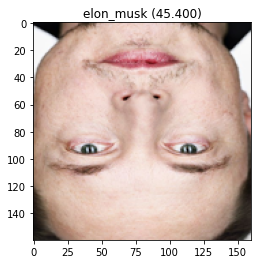

Predicted: elon_musk (56.999)
Expected: elon_musk


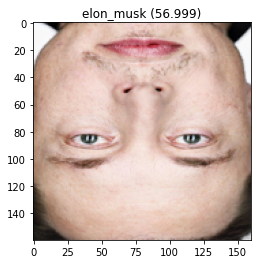

Predicted: elon_musk (56.774)
Expected: elon_musk


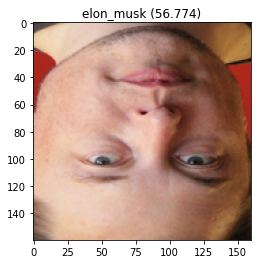

Predicted: elon_musk (93.559)
Expected: elon_musk


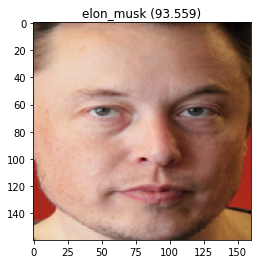

Predicted: elon_musk (63.290)
Expected: elon_musk


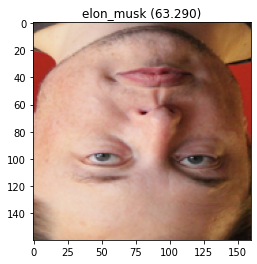

Predicted: elon_musk (92.426)
Expected: elon_musk


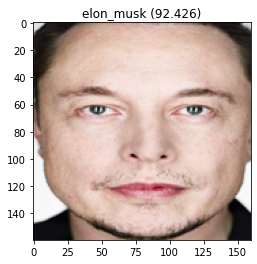

Predicted: elon_musk (89.126)
Expected: elon_musk


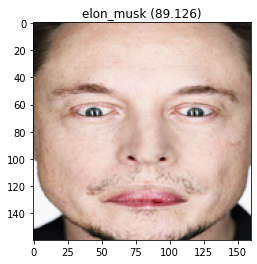

Predicted: elon_musk (91.647)
Expected: elon_musk


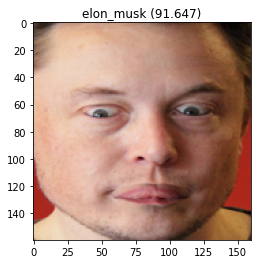

Predicted: bill_gates (89.676)
Expected: bill_gates


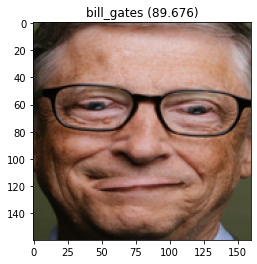

Predicted: bill_gates (52.134)
Expected: bill_gates


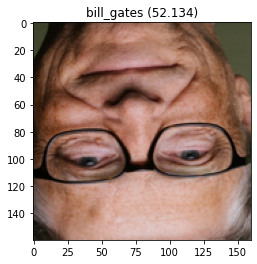

Predicted: bill_gates (50.651)
Expected: bill_gates


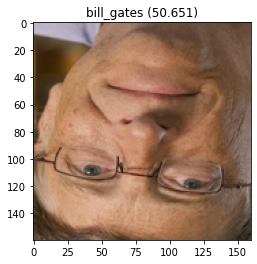

Predicted: bill_gates (45.020)
Expected: bill_gates


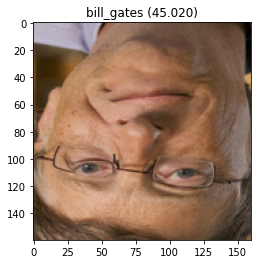

Predicted: elon_musk (46.579)
Expected: bill_gates


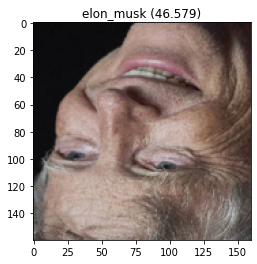

Predicted: elon_musk (59.842)
Expected: bill_gates


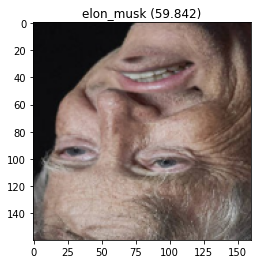

Predicted: bill_gates (46.396)
Expected: bill_gates


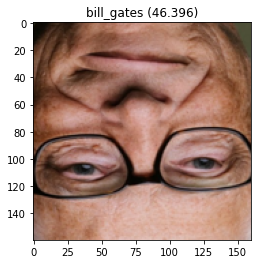

Predicted: bill_gates (93.498)
Expected: bill_gates


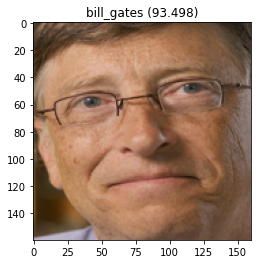

Predicted: bill_gates (90.053)
Expected: bill_gates


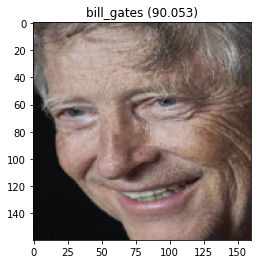

Predicted: bill_gates (92.533)
Expected: bill_gates


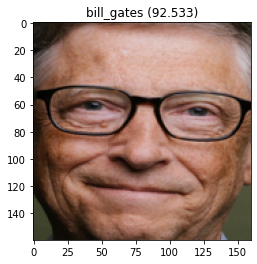

Predicted: bill_gates (78.516)
Expected: bill_gates


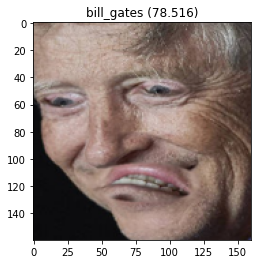

Predicted: bill_gates (93.297)
Expected: bill_gates


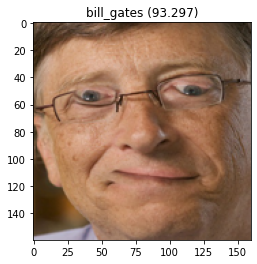

Predicted: elon_musk (60.368)
Expected: jeff_bezos


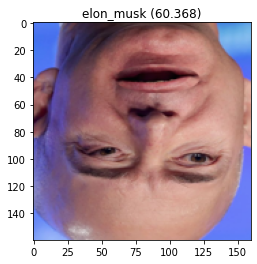

Predicted: elon_musk (62.648)
Expected: jeff_bezos


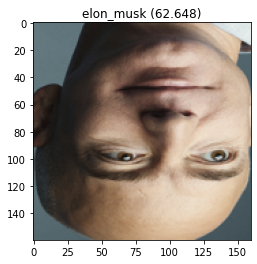

Predicted: elon_musk (68.723)
Expected: jeff_bezos


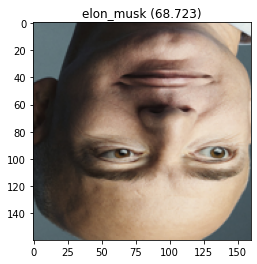

Predicted: jeff_bezos (94.249)
Expected: jeff_bezos


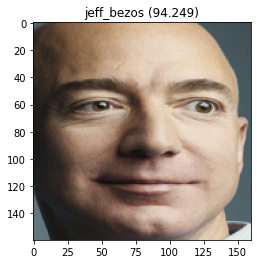

Predicted: jeff_bezos (91.149)
Expected: jeff_bezos


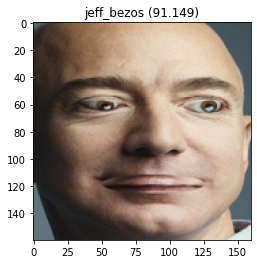

Predicted: jeff_bezos (88.094)
Expected: jeff_bezos


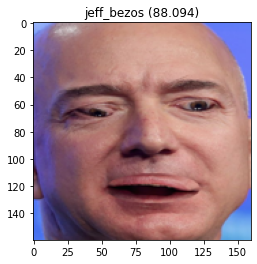

Predicted: jeff_bezos (91.639)
Expected: jeff_bezos


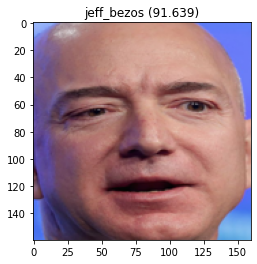

Predicted: elon_musk (55.402)
Expected: jeff_bezos


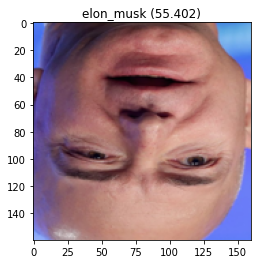

In [61]:
from random import choice
from numpy import load
from numpy import expand_dims
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
from matplotlib import pyplot
# load faces
data = load('/content/tech-faces-dataset.npz')
testX_faces = data['arr_2']
# load face embeddings
data = load('/content/tech-faces-embeddings.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
# normalize input vectors
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(trainX)
testX = in_encoder.transform(testX)
# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
testy = out_encoder.transform(testy)
# fit model
model = SVC(kernel='linear', probability=True)
model.fit(trainX, trainy)
# test model on a random example from the test dataset
for i in range(testX.shape[0]):
  selection = i
  random_face_pixels = testX_faces[selection]
  random_face_emb = testX[selection]
  random_face_class = testy[selection]
  random_face_name = out_encoder.inverse_transform([random_face_class])
  # prediction for the face
  samples = expand_dims(random_face_emb, axis=0)
  yhat_class = model.predict(samples)
  yhat_prob = model.predict_proba(samples)
  # get name
  class_index = yhat_class[0]
  class_probability = yhat_prob[0,class_index] * 100
  predict_names = out_encoder.inverse_transform(yhat_class)
  print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
  print('Expected: %s' % random_face_name[0])
  # plot for fun
  pyplot.imshow(random_face_pixels)
  title = '%s (%.3f)' % (predict_names[0], class_probability)
  pyplot.title(title)
  pyplot.show()
#selection = choice([i for i in range(testX.shape[0])])



https://machinelearningmastery.com/how-to-perform-face-recognition-with-vggface2-convolutional-neural-network-in-keras/
